In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
from quaternion import Quaternion

In [4]:
def scale_value(value, max_value, max_angle):
    return round((abs(value) / max_angle) * max_value)

def scale_roll(roll, scale):
    return scale_value(roll, scale, 180)

def scale_pitch(pitch, scale):
    return scale_value(pitch, scale, 90)
    
def calculate_expected_pitch(truth_value, scale):
    if scale == 49:
        return (truth_value / 49.0) * 90
    elif scale == 100:
        return (truth_value / 100.0) * 90
    
def calculate_expected_roll(truth_value, scale):
    if scale == 49:
        return (truth_value / 49.0) * 180
    elif scale == 100:
        return (truth_value / 100.0) * 180
   
stimuli = []   
 
scale_type = {
    "gesture_pitch_number": 100,
    "gesture_pitch_greyscale": 49,
    "gesture_roll_number": 100,
    "gesture_roll_greyscale": 49,
    "slider_number": 1,
    "slider_greyscale": 1,
}

euler_type = {
    "gesture_pitch_number": "XYZ",
    "gesture_pitch_greyscale": "XYZ",
    "gesture_roll_number": "XYZ",
    "gesture_roll_greyscale": "XYZ",
    "slider_number": "XYZ",
    "slider_greyscale": "XYZ",
}

with open('experiment_data/combined_participant_data.json', 'r') as file:
    data = json.load(file)

    if data:
        for participant in data:
            for experiment in participant["completedExperiments"]:
                experiment_type = experiment.get("experimentType")
                for stimulus in experiment["successfulStimuli"]:
                    sensor_reading = stimulus.get("sensorReading", {})
                    quaternion = Quaternion(
                        sensor_reading.get("w"),
                        sensor_reading.get("x"),
                        sensor_reading.get("y"),
                        sensor_reading.get("z")
                    )
                    if None not in quaternion:
                        yaw, pitch, roll = quaternion.euler_angles(euler_type[experiment_type])
                    
                        pitch_deg = math.degrees(pitch)
                        roll_deg = math.degrees(roll)
                        
                        sensor_reading["roll"] = roll_deg
                        sensor_reading["pitch"] = pitch_deg

                        pitch_scaled = scale_pitch(pitch_deg, scale_type[experiment_type])
                        roll_scaled = scale_roll(roll_deg, scale_type[experiment_type])
                        truth_value = stimulus.get("truth")
                        expected_pitch = calculate_expected_pitch(truth_value, scale_type[experiment_type])
                        expected_roll = calculate_expected_roll(truth_value, scale_type[experiment_type])

                        stimulus["pitch"] = pitch_deg
                        stimulus["expected_pitch"] = expected_pitch
                        stimulus["pitch_truth"] = pitch_scaled
                        stimulus["pitch_truth_diff"] = abs(truth_value - pitch_scaled)
                        stimulus["roll"] = roll_deg
                        stimulus["expected_roll"] = expected_roll
                        stimulus["roll_truth"] = roll_scaled
                        stimulus["roll_truth_diff"] = abs(truth_value - roll_scaled)
                        stimulus["experiment_type"] = experiment_type
                        
                        stimuli.append(stimulus)

df = pd.DataFrame(data=stimuli)

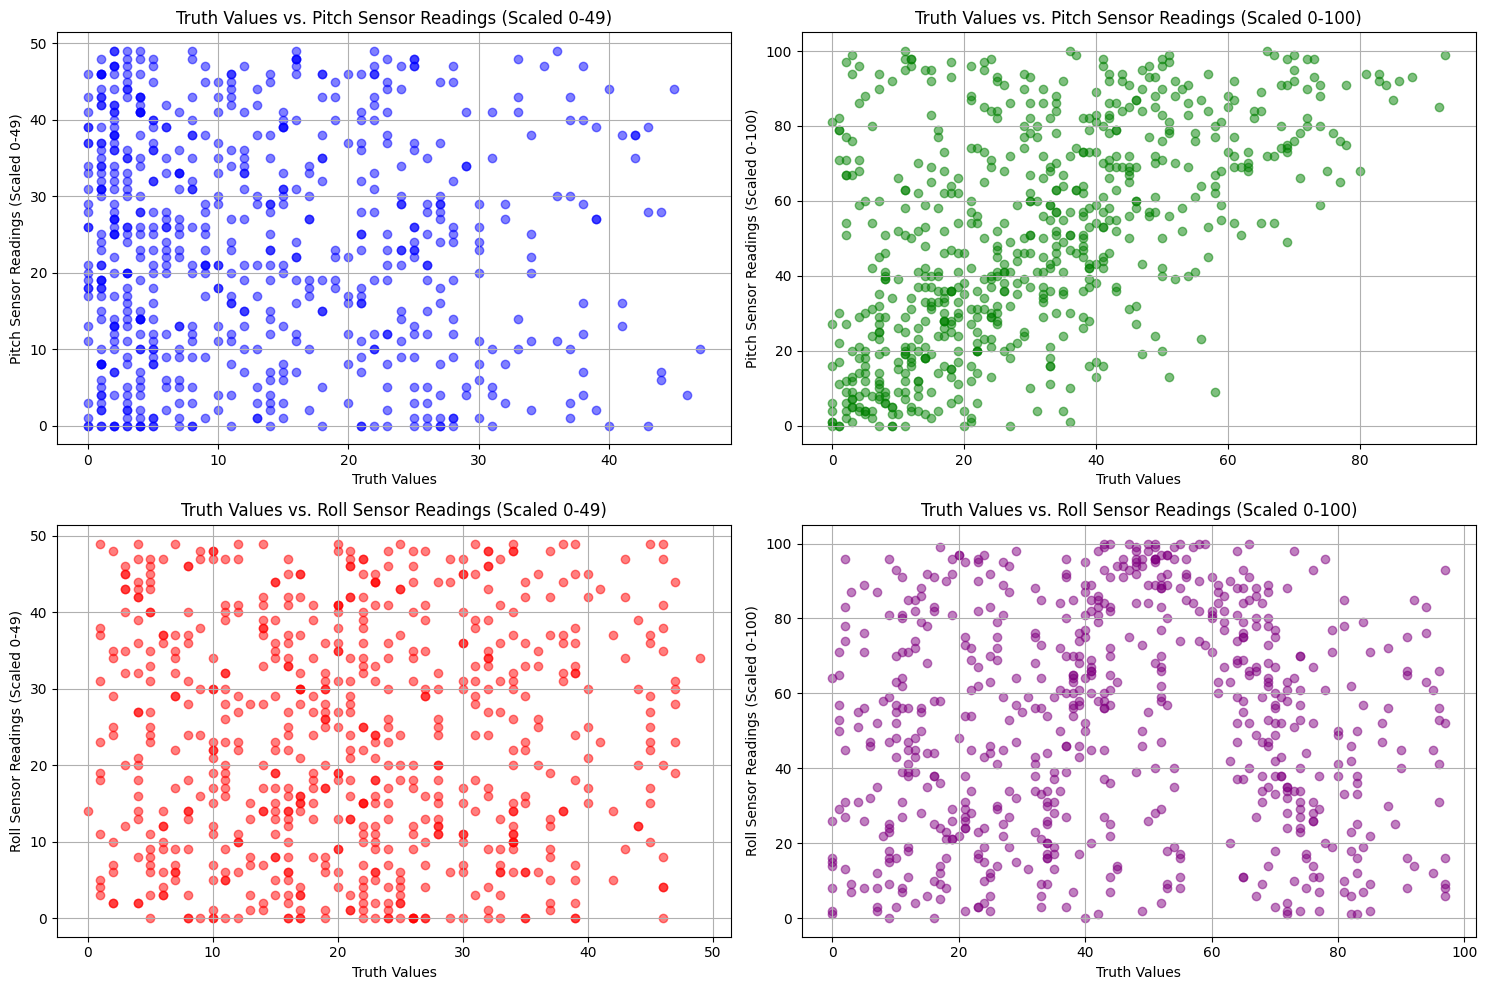

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

g_pitch_greyscale_df = df[df["experiment_type"] == "gesture_pitch_greyscale"]

axes[0, 0].scatter(g_pitch_greyscale_df["pitch_truth"], g_pitch_greyscale_df["truth"], c='blue', alpha=0.5)
axes[0, 0].set_title('Truth Values vs. Pitch Sensor Readings (Scaled 0-49)')
axes[0, 0].set_xlabel('Truth Values')
axes[0, 0].set_ylabel('Pitch Sensor Readings (Scaled 0-49)')
axes[0, 0].grid(True)

g_pitch_number_df = df[df["experiment_type"] == "gesture_pitch_number"]

axes[0, 1].scatter(g_pitch_number_df["pitch_truth"], g_pitch_number_df["truth"], c='green', alpha=0.5)
axes[0, 1].set_title('Truth Values vs. Pitch Sensor Readings (Scaled 0-100)')
axes[0, 1].set_xlabel('Truth Values')
axes[0, 1].set_ylabel('Pitch Sensor Readings (Scaled 0-100)')
axes[0, 1].grid(True)

g_roll_greyscale_df = df[df["experiment_type"] == "gesture_roll_greyscale"]

axes[1, 0].scatter(g_roll_greyscale_df["roll_truth"], g_roll_greyscale_df["truth"], c='red', alpha=0.5)
axes[1, 0].set_title('Truth Values vs. Roll Sensor Readings (Scaled 0-49)')
axes[1, 0].set_xlabel('Truth Values')
axes[1, 0].set_ylabel('Roll Sensor Readings (Scaled 0-49)')
axes[1, 0].grid(True)

g_roll_number_df = df[df["experiment_type"] == "gesture_roll_number"]

axes[1, 1].scatter(g_roll_number_df["roll_truth"], g_roll_number_df["truth"], c='purple', alpha=0.5)
axes[1, 1].set_title('Truth Values vs. Roll Sensor Readings (Scaled 0-100)')
axes[1, 1].set_xlabel('Truth Values')
axes[1, 1].set_ylabel('Roll Sensor Readings (Scaled 0-100)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()